# B2 Conditioning Gaussian processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
import pyro

# B2.3 Learning with Integral Constraints 

In [ ]:
#running Seb's code to get gpr kernel and plot function

%run ../Sebastian/taskb1.ipynb

In [ ]:
# generate data x

l=101
x=torch.tensor(np.linspace(0,1,l))

# generate weights w

w=torch.ones_like(x)*1/(l-1)
w[0]=0.5/(l-1)
w[-1]=0.5/(l-1)


tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000], dtype=torch.float64)
tensor([0.0050, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.

Derive the probability distribution of the random variable $(\hat{q},f)|X$.

The random variable is normally distributed with mean $0$ and variance $Qk(X)Q^T$, where $k(X)=(k(x_i,x_j))_{i,j=1}^n$ and $Q=(w, 1_l)^T\in \mathbb{R}^{(l+1)\times(l+1)}$ a matrix with weights $(w_i)_{i=1}^n$ stacked on top of the identity matrix in $l$ dimensions $1_l$.



Note: $w\in \mathbb{R}^{l\times1}$ 

Similarly, the distribution of the random variable $f|X,\hat{q}$ can be calculated to be the following:

The random variable is normally distributed with mean $\mu_{2|1}=(\langle w,k(x,x_i)\rangle)_{i=1}^n\cdot \frac{\hat{q}}{w^Tk(X)w}$ and covariance $\Sigma_{2|1}=k(X)-(\langle w,k(x,x_i)\rangle)_{i=1}^n \frac{1}{w^Tk(X)w}((\langle w,k(x,x_i)\rangle)_{i=1}^n)^T$.

In [34]:
def sample_given_q(x,w,q,kernel): #give kernel as a function in one argument
    
    sigma_12=torch.zeros_like(w)

    for i in range(len(x)):
        #returns sum_i w_i * kernel(x_i,x) a vector of len l
        sigma_12[i]= w @ kernel(x,x[i]) 

    
    sigma_11= w @ kernel(x,x) @ w.T #should be a scalar

    sigma_cond = kernel(x,x) - (torch.outer(sigma_12, sigma_12)*(1/sigma_11)) #outer product sigma_12*sigma_12.T
    mu_cond= sigma_12 *(q/sigma_11) #should be a vector of length l
    return mu_cond,sigma_cond

mu, cov = sample_given_q(x.unsqueeze(1),w,5,gpr.kernel)




In [35]:
def sample_from_conditional(mu_cond, cov_cond, num_samples=1):
    eigvals, eigvecs = torch.linalg.eigh(cov_cond)
    L = eigvecs @ torch.diag(torch.sqrt(eigvals.clamp(min=1e-8)))
    z = torch.randn((cov_cond.shape[0], num_samples)).float()
    L = L.float()

    mu_cond = mu_cond.unsqueeze(1).float()
    samples = mu_cond + L @ z
    return samples.reshape(z.shape[0],num_samples)

# Generate samples
samples = sample_from_conditional(mu, cov, num_samples=5)


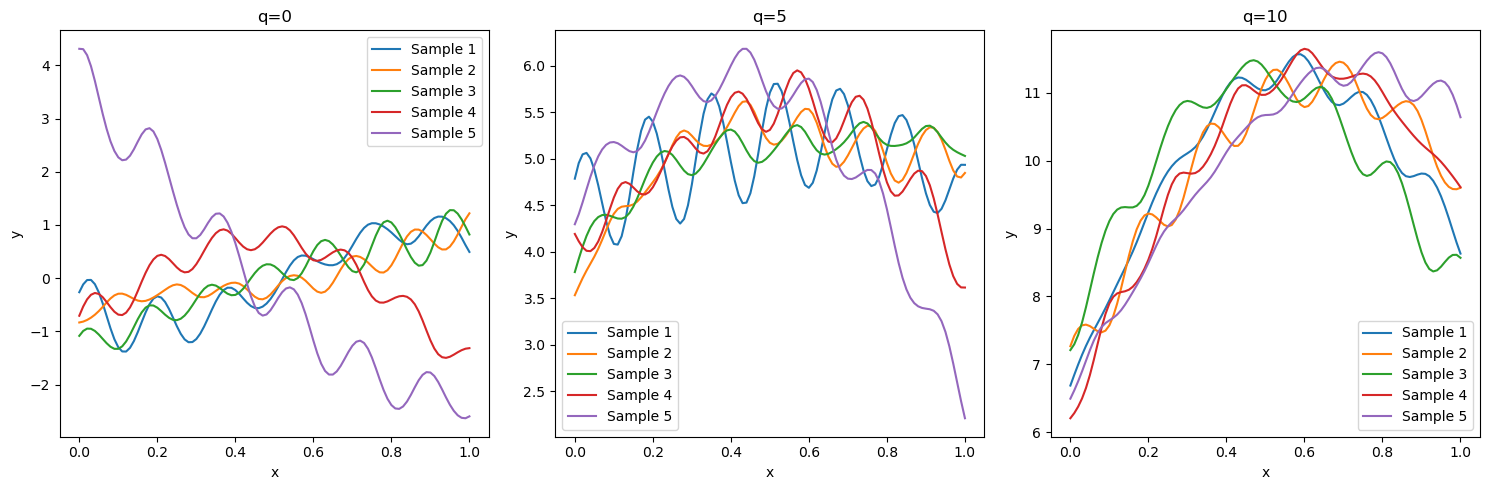

In [36]:
gpr.kernel.eval()

import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Loop over the q values and the axes
for ax, q in zip(axs, [0, 5, 10]):
    # Compute mean and covariance
    mu, cov = sample_given_q(x.unsqueeze(1), w, q, gpr.kernel)
    
    # Sample from the conditional distribution
    samples = sample_from_conditional(mu, cov, num_samples=5).detach().numpy()
    
    # Plot each sample in the current subplot
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:, i], label="Sample " + str(i + 1))
    
    # Set title and labels for the subplot
    ax.set_title(f"q={q}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


# B2.4 Computing posteriors given data $\mathcal{D}$

In [32]:
def g(x):
    return -torch.sin(6 * math.pi * x)**2 + 6*(x**2) - 5*(x**4) + 3/2

here


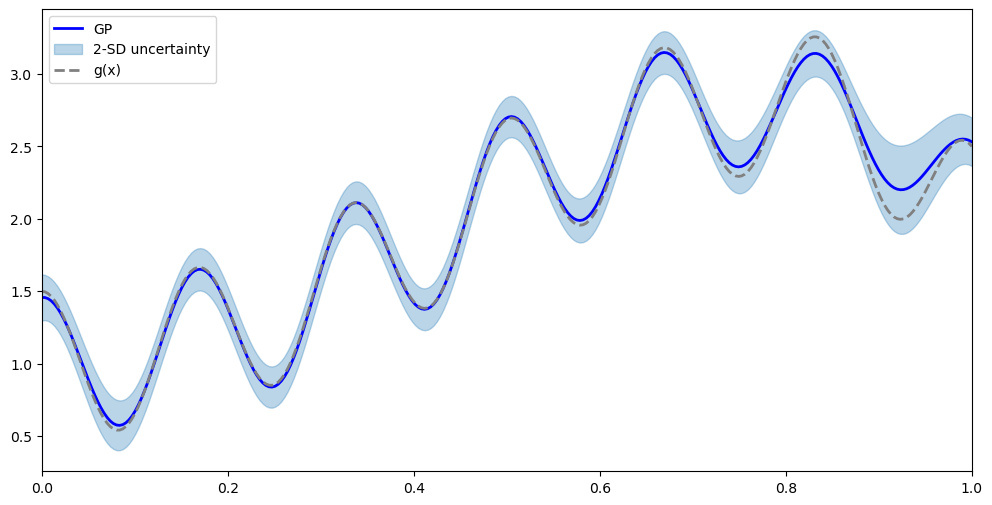

In [33]:
data_x = torch.tensor([0,0.25,0.5],dtype=torch.float64)
data_y = torch.tensor([1.46,0.93,2.76],dtype=torch.float64)
plot(model=gpr, plot_observed_data=False, plot_predictions=True)

In [28]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Convert numpy arrays to PyTorch tensors
    X1 = torch.tensor(X1)
    X2 = torch.tensor(X2)
    
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * torch.eye(3))
    Σ11 = Σ11.detach().numpy()
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    Σ12 = Σ12.detach().numpy()
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    
    # Compute posterior mean
    μ2 = solved @ y1
    
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ22 = Σ22.detach().numpy()
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance


def GP_noise_restricted(mean, cov, σ_noise):
    #get first 3 dim submatrix of cov
    cov_11 = cov[:3,:3]
    cov_12 = cov[:3,3:].detach().numpy()
    cov_22 = cov[3:,3:].detach().numpy()

    mean_1 = mean[:3].detach().numpy()
    mean_2 = mean[3:].detach().numpy()

    # Kernel of the noisy observations
    Σ11 = cov_11 + ((σ_noise ** 2) * torch.eye(3))
    Σ11 = Σ11.detach().numpy()

    # Kernel of observations vs to-predict
    Σ12 = cov_12

    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

    y1= data_y.detach().numpy()
    y_1 = y1 - mean_1

    y_1= y_1.reshape(-1,1)

    # Compute posterior mean
    μ2 = mean_2.reshape(-1,1) + solved @ y_1
    #make mu one dimensional
    μ2 = μ2.flatten()

    # Compute the posterior covariance
    Σ22 = cov_22

    Σ2 = Σ22 - (solved @ Σ12)

    return μ2, Σ2  # mean, covariance




In [29]:
x_new = [0,0.25,0.5]
x_new = np.append(x_new, np.delete(x, [0,25,50]))
x_new = torch.tensor(x_new)


# Sample from the restricted Gaussian process
q=2
mean, cov = sample_given_q(x_new.unsqueeze(1), w, q, gpr.kernel)


In [30]:
σ_noise = np.sqrt(0.01)  # The standard deviation of the noise

# Compute the posterior mean and covariance
σ_noise = np.sqrt(0.01)  # The standard deviation of the noise

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(data_x.detach().numpy() , data_y.detach().numpy() , x.detach().numpy(), gpr.kernel, σ_noise)

# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=5)


print('The function integrates to ', y2[0]@w.detach().numpy())


############################################################################################################

μ2_restricted, Σ2_restricted = GP_noise_restricted(mean, cov, σ_noise)

# Compute the standard deviation at the test points to be plotted
σ2_restricted = np.sqrt(np.diag(Σ2_restricted))

# Draw one samples of the posterior
y2_restricted = np.random.multivariate_normal(mean=μ2_restricted, cov=Σ2_restricted, size=1).T

# Ensure y2 has the same number of columns as data_y
y2_restricted = y2_restricted.reshape(-1, 1)

y_values= np.append(data_y.unsqueeze(1).detach().numpy(), y2_restricted, axis=0)
y_values = y_values.flatten()

print('The function integrates to ',y_values @ w.detach().numpy())

# generate 5 samples for plotting
y_5 = np.random.multivariate_normal(mean=μ2_restricted, cov=Σ2_restricted, size=5).T


The function integrates to  2.309867593528751
The function integrates to  1.9999678453823038


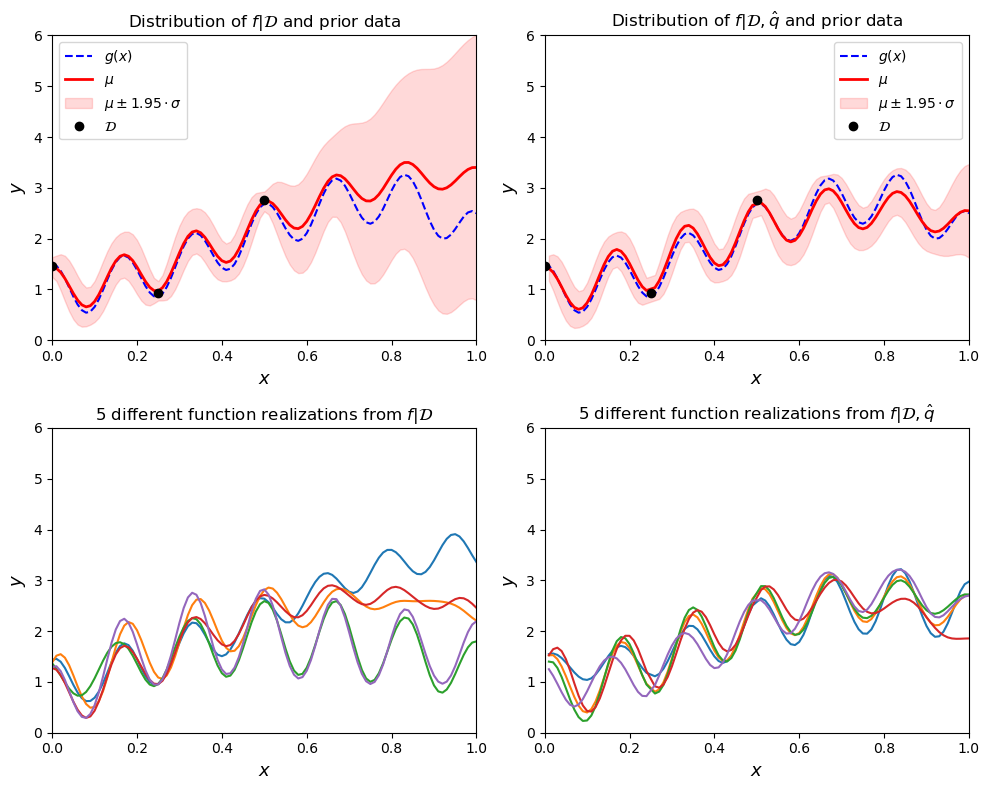

In [31]:
xrange=[0,1]
yrange=[0,6]

# Plot the postior distribution and some samples
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 8))
(ax1, ax3), (ax2, ax4) = axs

# Plot the distribution of the function (mean, covariance)
ax1.plot(x, g(x), 'b--', label='$g(x)$')
ax1.plot(x, μ2, 'r-', lw=2, label='$\mu$')
ax1.fill_between(x.detach().numpy().flat, μ2-1.95*σ2, μ2+1.95*σ2, color='red', 
                 alpha=0.15, label='$\mu \pm 1.95\cdot\sigma$')
ax1.plot(data_x, data_y, 'ko', linewidth=2, label='$\mathcal{D}$')
#limit xrange
ax1.set_xlim(xrange)
ax1.set_ylim(yrange)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of $f|\mathcal{D}$ and prior data')
ax1.legend()

# Plot some samples from this function
ax2.plot(x, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_xlim(xrange)
ax2.set_ylim(yrange)
ax2.set_title('5 different function realizations from $f|\mathcal{D}$')

# Plot the distribution of the function (mean, covariance)
ax3.plot(x, g(x), 'b--', label='$g(x)$')
ax3.plot(np.delete(x, [0,25,50]), μ2_restricted, 'r-', lw=2, label='$\mu$')
ax3.fill_between(np.delete(x, [0,25,50]).detach().numpy().flat, μ2_restricted-1.95*σ2_restricted, μ2_restricted+1.95*σ2_restricted, color='red', 
                 alpha=0.15, label='$\mu \pm 1.95\cdot\sigma$')



ax3.plot(data_x, data_y, 'ko', linewidth=2, label='$\mathcal{D}$')
ax3.set_xlabel('$x$', fontsize=13)
ax3.set_ylabel('$y$', fontsize=13)
ax3.set_title('Distribution of $f|\mathcal{D},\hat{q}$ and prior data')
ax3.set_xlim(xrange)
ax3.set_ylim(yrange)
ax3.legend()

# Plot some samples from this function
ax4.plot(np.delete(x, [0,25,50]), y_5, '-')
ax4.set_xlabel('$x$', fontsize=13)
ax4.set_ylabel('$y$', fontsize=13)
ax4.set_xlim(xrange)
ax4.set_ylim(yrange)
ax4.set_title('5 different function realizations from $f|\mathcal{D},\hat{q}$')

plt.tight_layout()
plt.show()


# Doing stuff that did not work

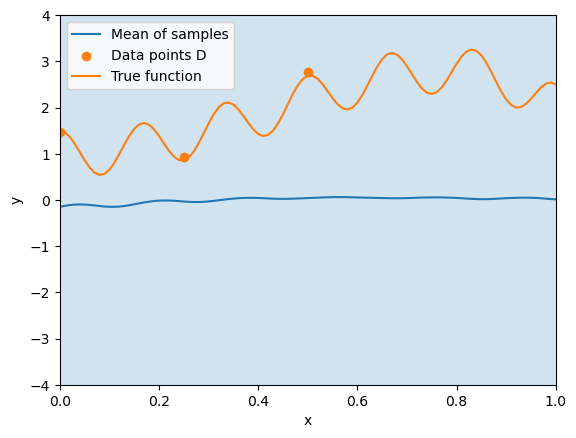

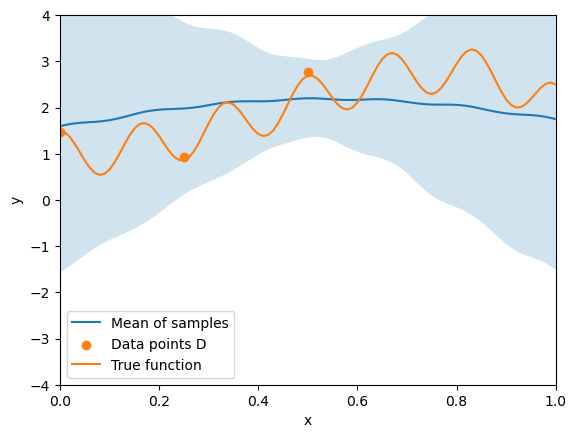

tensor(2.0000, grad_fn=<DotBackward0>)


In [ ]:
# sampling 100 samples and plotting mean and variance of these samples

gpr.kernel.eval()


# get the samples from f|D,X 
samples_uncond= sample_from_conditional(torch.zeros_like(x),gpr1.kernel(x,x),num_samples=100).detach().numpy()
mean_samples_uncond=np.mean(samples_uncond,axis=1)
var_samples_uncond=np.var(samples_uncond,axis=1)

fig, axs = plt.subplots()  # Adjust figsize as needed

axs.plot(x, mean_samples_uncond, label="Mean of samples")
axs.fill_between(x, mean_samples_uncond-2*np.sqrt(var_samples_uncond), mean_samples_uncond+2*np.sqrt(var_samples_uncond), alpha=0.2)
axs.scatter(data_x, data_y, label="Data points D")
axs.plot(x,g(x), label="True function")
# fix axis range
axs.set_xlim([0, 1])
axs.set_ylim([-4, 4])

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend()

plt.show()


fig, ax = plt.subplots()  # Adjust figsize as needed

# get the samples from f|D,X,q
mu, cov = sample_given_q(x.unsqueeze(1), w, 2, gpr.kernel)
    
# Sample from the conditional distribution
samples = sample_from_conditional(mu, cov, num_samples=100)
samples_plot = samples.detach().numpy()

#get the mean of the samples
mean_samples=np.mean(samples_plot,axis=1)
var_samples=np.var(samples_plot,axis=1) 

'''
# Plot each sample in the current subplot
for i in range(samples_plot.shape[1]):
    ax.plot(x, samples_plot[:, i], label="Sample " + str(i + 1))
'''

ax.plot(x, mean_samples, label="Mean of samples")
ax.fill_between(x, mean_samples-2*np.sqrt(var_samples), mean_samples+2*np.sqrt(var_samples), alpha=0.2)

ax.scatter(data_x, data_y, label="Data points D")
ax.plot(x,g(x), label="True function")
# Set title and labels for the subplot
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([0, 1])
ax.set_ylim([-4, 4])

ax.legend()

plt.show()

# check if it works
print(samples[:,3].float() @ w.float())

/var/folders/16/r76sng_n05zfpw9mshyz8xbc0000gn/T/ipykernel_12515/1317006411.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, cov = gpr1(torch.tensor(x), full_cov = True, noiseless = False)
/var/folders/16/r76sng_n05zfpw9mshyz8xbc0000gn/T/ipykernel_12515/1317006411.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.plot(x, g(torch.tensor(x)),  "grey", linestyle = "dashed", lw=2, label = 'g(x)')


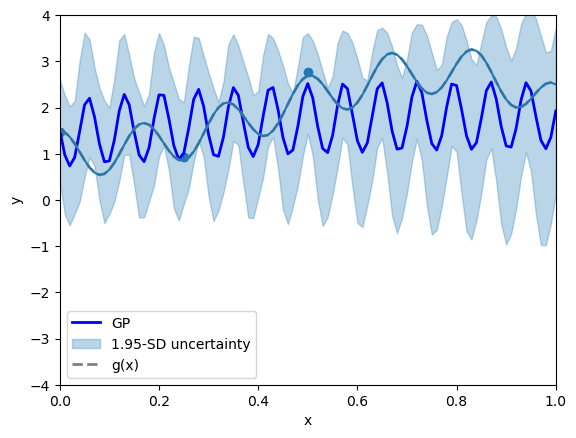

/var/folders/16/r76sng_n05zfpw9mshyz8xbc0000gn/T/ipykernel_12515/1317006411.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.plot(x, g(torch.tensor(x)),  "grey", linestyle = "dashed", lw=2, label = 'g(x)')


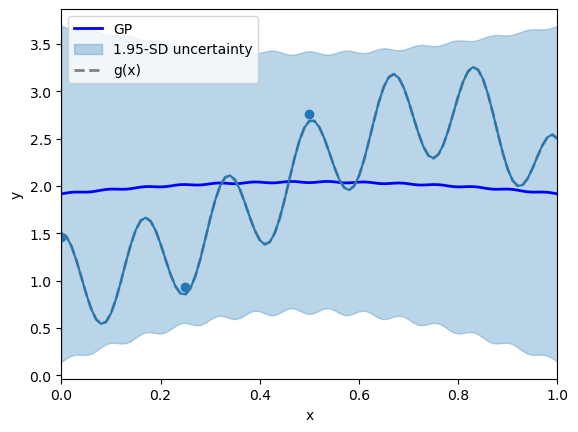

In [ ]:

with torch.no_grad():
    mean, cov = gpr1(torch.tensor(x), full_cov = True, noiseless = False)
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt()
    sd = sd.detach().numpy()


fig, ax = plt.subplots()  # Adjust figsize as needed
ax.plot(x, mean, "b", lw=2, label = 'GP')
ax.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 1.95 * sd),
    (mean + 1.95 * sd),
    color="C0",
    alpha=0.3,
    label='1.95-SD uncertainty'
)

ax.plot(x, g(torch.tensor(x)),  "grey", linestyle = "dashed", lw=2, label = 'g(x)')
ax.legend()
ax.scatter(data_x, data_y, label="Data points D")
ax.plot(x,g(x), label="True function")
# Set title and labels for the subplot
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([0, 1])
ax.set_ylim([-4, 4])
plt.show()




with torch.no_grad():
    mean, cov = sample_given_q(x.unsqueeze(1), w, 2, gpr1.kernel)
    mean = mean.detach().numpy()
    sd = cov.diag().sqrt()
    sd = sd.detach().numpy()

fig, ax = plt.subplots()  # Adjust figsize as needed
ax.plot(x, mean, "b", lw=2, label = 'GP')
ax.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd),
    (mean + 2.0 * sd),
    color="C0",
    alpha=0.3,
    label='1.95-SD uncertainty'
)

ax.plot(x, g(torch.tensor(x)),  "grey", linestyle = "dashed", lw=2, label = 'g(x)')
ax.legend()

ax.scatter(data_x, data_y, label="Data points D")
ax.plot(x,g(x), label="True function")
# Set title and labels for the subplot
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([0, 1])

plt.show()

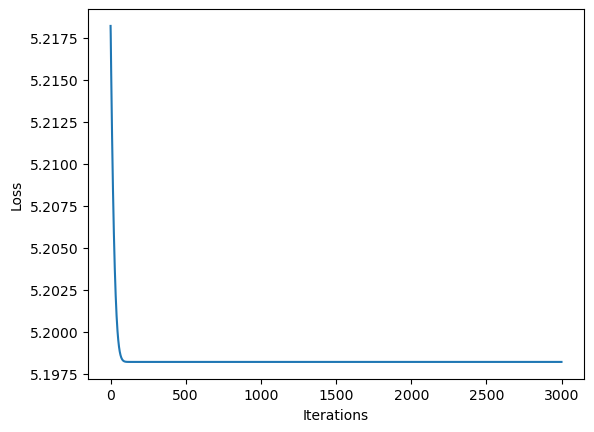

In [ ]:
pyro.clear_param_store()

'''
gpr1 = get_gpr(data_x, data_y, variance_prior_periodic, lengthscale_prior_periodic,
              period_prior, variance_prior_rbf, lengthscale_prior_rbf, noise_prior)


optimizer = torch.optim.Adam(gpr1.parameters(), lr=0.002)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr1.model, gpr1.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)
'''

